In [15]:
import pandas as pd 
pd.options.display.max_columns = 100
import numpy as np
from scipy.stats import stats
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline


train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
testId = test.Id

In [16]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


1.8828757597682129
6.536281860064529


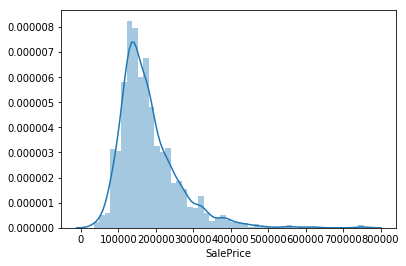

In [17]:
print(train['SalePrice'].skew())
print(train['SalePrice'].kurt())
sns.distplot(train['SalePrice'])

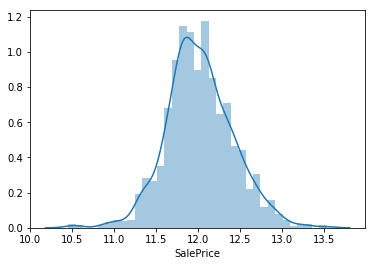

In [18]:
train['SalePrice'] = np.log1p(train['SalePrice'])
sns.distplot(train['SalePrice'])

In [19]:
all_data = pd.concat([train.loc[:, 'MSSubClass':'SaleCondition'],
                    test.loc[:, 'MSSubClass':'SaleCondition']])

numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
all_data[numeric_feats] = all_data[numeric_feats].apply(lambda x: np.log1p(x) if x.skew()>0.5 else x)

all_data = pd.get_dummies(all_data)
all_data.fillna(all_data.mean(), inplace=True)

X_train = all_data[: train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train['SalePrice']

## 不借助第三方库

In [20]:
"""
    标准线性回归
"""
def standRegres(xArr, yArr):
    xMat = np.mat(xArr); yMat=np.mat(yArr).T
    xTx = xMat.T * xMat 
    if np.linalg.det(xTx) == 0:
        print("The matrix is singular, cannot do inverse")
        return
    ws = xTx.I * (xMat.T * yMat)
    return ws 


ws = standRegres(X_train, y)

y_preds = (np.mat(X_test) * ws).T

## sklearn

In [25]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split


kfolds = KFold(n_splits=10, shuffle=True, random_state=42)


X_train, X_test, y_train, y_test = train_test_split(X_train, y, 
                                                    test_size=0.33,
                                                    random_state=0)

In [21]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring='neg_mean_squared_error', cv=5))
    return rmse

model_ridge = Ridge()
alphas = [0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas]

Text(0,0.5,'rmse')

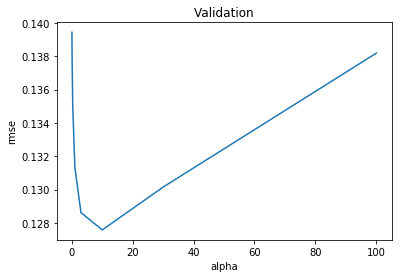

In [22]:
cv_ridge = pd.Series(cv_ridge, index=alphas)
cv_ridge.plot(title='Validation')
plt.xlabel('alpha')
plt.ylabel('rmse')

In [23]:
cv_ridge.min()

0.1275845312251826

In [24]:
alphas=[1, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001]
model_lasso = LassoCV(alphas=alphas, max_iter=20000).fit(X_train, y)
rmse_cv(model_lasso).mean()

0.12493981729048213

In [11]:
for alpha in alphas:
    model_lasso = LassoCV(alpha, max_iter=50000).fit(X_train, y)
    print(alpha, rmse_cv(model_lasso), rmse_cv(model_lasso).mean())

1 [0.38677605 0.42513731 0.40996858 0.38299663 0.39124987] 0.39922568603836983
0.3 [0.2943137  0.32661156 0.32514158 0.31051156 0.31088459] 0.3134925986992932
0.1 [0.28350831 0.31119626 0.31418553 0.30782025 0.3081719 ] 0.3049764513651272
0.03 [0.25519077 0.28147201 0.28516419 0.28052506 0.28272229] 0.2770148663483651
0.01 [0.24487465 0.2716083  0.26506762 0.26489646 0.27698246] 0.26468589759318967
0.003 [0.23789544 0.26412747 0.25485743 0.25843086 0.27361431] 0.25778510139058564
0.001 [0.18716398 0.21013631 0.20147985 0.19300739 0.21264572] 0.20088665232281827
0.0003 [0.15235046 0.17632147 0.16600097 0.15548403 0.18106536] 0.16624445757618903
0.0001 [0.13174253 0.15501984 0.14832009 0.13443229 0.16980264] 0.14786347847870868
3e-05 [0.10901351 0.13881309 0.13111727 0.11376168 0.15215797] 0.1289727036450014
1e-05 [0.10395399 0.13251232 0.12445599 0.10825565 0.1463297 ] 0.12310153019393573


In [12]:
preds = model_lasso.predict(X_test)
solution = pd.DataFrame({'id':test.Id, 'SalePrice':np.expm1(preds)})
solution.to_csv('linear_sol.csv', index=False)

In [13]:
preds

array([11.69088272, 11.93928127, 12.10957439, ..., 12.02977826,
       11.68924528, 12.33378407])

In [26]:
alphas_ridge = [1,3,10, 100, 14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
model_ridge = RidgeCV(alphas=[10], cv=kfolds)
rmse_cv(model_ridge.fit(X_train, y))

# for alpha in alphas_ridge:
#     model_ridge = RidgeCV(alphas=[alpha], cv=kfolds)
#     print(alpha, rmse_cv(model_ridge).mean())

array([0.11111691, 0.13814161, 0.12614568, 0.11194806, 0.1505704 ])

In [27]:
svr = make_pipeline(RobustScaler(), SVR(C=20, epsilon=0.008, gamma=0.0003))
svr.fit(X_train, y)
print(rmse_cv(svr), rmse_cv(svr).mean())

[0.10180521 0.13921723 0.1210353  0.10344578 0.15054099] 0.12320890174561376


In [28]:
lasso_pred = model_lasso.predict(X_test)
ridge_pred = model_ridge.predict(X_test)
svr_pred = svr.predict(X_test)

pred = 0.33*lasso_pred + 0.33*svr_pred + 0.33*ridge_pred
solution = pd.DataFrame({'id':test.Id, 'SalePrice':np.expm1(preds)})
solution.to_csv('submission_2019-12-08.csv', index=False)